
# Resume Category Classifier — TF-IDF + LinearSVC (Notebook)

This notebook trains a text classifier for resume categories using **TF-IDF + LinearSVC** and saves artifacts **compatible with your `app.py` Streamlit app**:

- `tfidf.pkl` — fitted `TfidfVectorizer`
- `clf.pkl` — fitted `LinearSVC` classifier

> Data path: by default this notebook uses `/mnt/data/data.csv` (already uploaded).  
> The CSV must have two columns: `Category` (string label) and `Resume` (text).

Run cells top-to-bottom. When finished, place the generated `tfidf.pkl` and `clf.pkl`
next to your `app.py` and run your Streamlit app.


In [1]:

# Imports
import os
import re
import json
import pickle
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

DATA_PATH = "data.csv"   # Change if needed
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Optional plotting (safe to ignore if not installed)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    _HAS_PLOTS = True
except Exception:
    _HAS_PLOTS = False

print('Using data at:', DATA_PATH)


Using data at: data.csv


In [2]:

# Load data
assert os.path.exists(DATA_PATH), f"Data not found at {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
required_cols = {"Category", "Resume"}
missing = list(required_cols - set(df.columns))
assert not missing, f"CSV missing required columns: {missing}"

df = df[list(required_cols)].dropna()
print(df.shape)
df.head()


(962, 2)


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


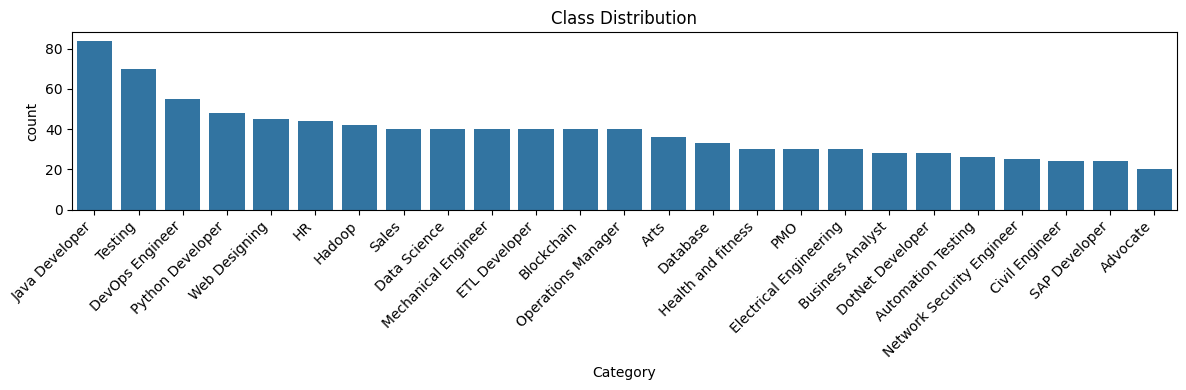

Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Sales                        40
Data Science                 40
Mechanical Engineer          40
ETL Developer                40
Blockchain                   40
Operations Manager           40
Arts                         36
Database                     33
Health and fitness           30
PMO                          30
Electrical Engineering       30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
Civil Engineer               24
SAP Developer                24
Advocate                     20
Name: count, dtype: int64

In [3]:

# Optional: Class distribution plots
if _HAS_PLOTS:
    plt.figure(figsize=(12,4))
    order = df["Category"].value_counts().index
    sns.countplot(x="Category", data=df, order=order)
    plt.xticks(rotation=45, ha="right")
    plt.title("Class Distribution")
    plt.tight_layout()
    plt.show()

df["Category"].value_counts()



### Text Cleaning

The function below fixes a common bug (each `re.sub` must build on the previous result, not the original text).  
Use the same logic in your `app.py` to ensure compatibility between training and inference.


In [4]:

CLEAN_PUNCT_KEEP = r"[^0-9a-zA-Z\s\.,\-\+_\/]"

def clean_resume(text: str) -> str:
    # Basic resume cleaner suitable for TF-IDF models.
    if not isinstance(text, str):
        text = str(text)

    t = text
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"\bRT\b|\bcc\b", " ", t, flags=re.IGNORECASE)
    t = re.sub(r"@[A-Za-z0-9_]+", " ", t)
    t = re.sub(r"#[A-Za-z0-9_]+", " ", t)
    t = re.sub(r"[\r\n\t]+", " ", t)
    t = re.sub(CLEAN_PUNCT_KEEP, " ", t)
    t = re.sub(r"\s{2,}", " ", t).strip()
    return t

# Quick check
print(clean_resume("Check this out: https://example.com @you #hashtag\nNew line\tTabs... OK!"))


Check this out New line Tabs... OK



### Label Mapping (to match your `app.py`)

Your Streamlit app expects the classifier to output integer IDs which map to category names via a fixed dictionary.
We will encode labels using that exact mapping so `clf.predict` returns the same integers your app expects.


In [5]:

# This mapping matches your app.py (id -> category)
id_to_category = {
    15: "Java Developer",
    23: "Testing",
    8: "DevOps Engineer",
    20: "Python Developer",
    24: "Web Designing",
    12: "HR",
    13: "Hadoop",
    3: "Blockchain",
    10: "ETL Developer",
    18: "Operations Manager",
    6: "Data Science",
    22: "Sales",
    16: "Mechanical Engineer",
    1: "Arts",
    7: "Database",
    11: "Electrical Engineering",
    14: "Health and fitness",
    19: "PMO",
    4: "Business Analyst",
    9: "DotNet Developer",
    2: "Automation Testing",
    17: "Network Security Engineer",
    21: "SAP Developer",
    5: "Civil Engineer",
    0: "Advocate",
}

# Invert to category -> id
category_to_id = {v: k for k, v in id_to_category.items()}

# Verify that all dataset labels are in the mapping
labels_in_data = set(df["Category"].unique())
labels_in_mapping = set(category_to_id.keys())
missing_in_mapping = labels_in_data - labels_in_mapping
extra_in_mapping = labels_in_mapping - labels_in_data

print("Categories in data:", len(labels_in_data))
print("Missing in mapping (should be empty):", missing_in_mapping)
if missing_in_mapping:
    print("Some labels in your data are not in app.py mapping. Consider updating app.py mapping.")

# Encode y using the fixed mapping
y = df["Category"].map(category_to_id)
assert not y.isna().any(), "Found labels not present in mapping. Please update mapping or data."
X = df["Resume"].astype(str).apply(clean_resume)


Categories in data: 25
Missing in mapping (should be empty): set()


In [6]:

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
len(X_train), len(X_test)


(769, 193)

In [7]:

# TF-IDF vectorizer
tfidf = TfidfVectorizer(
    stop_words="english",
    lowercase=True,
    strip_accents="unicode",
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True,
)

Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

# LinearSVC classifier
clf = LinearSVC(random_state=RANDOM_STATE)
clf.fit(Xtr, y_train)

# Evaluate
pred = clf.predict(Xte)
acc = (pred == y_test.values).mean()
print(f"Hold-out accuracy: {acc:.4f}")

# Detailed report (sorted by id order)
from sklearn.metrics import classification_report
ids_sorted = sorted(id_to_category.keys())
target_names = [id_to_category[i] for i in ids_sorted]
print("\nClassification report:\n")
print(classification_report(y_test, pred, labels=ids_sorted, target_names=target_names, zero_division=0))


Hold-out accuracy: 1.0000

Classification report:

                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         4
                     Arts       1.00      1.00      1.00         7
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       1.00      1.00      1.00         6
           Civil Engineer       1.00      1.00      1.00         5
             Data Science       1.00      1.00      1.00         8
                 Database       1.00      1.00      1.00         7
          DevOps Engineer       1.00      1.00      1.00        11
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         8
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00         9
          

In [8]:
# ✅ Fixed: 5-fold cross validation without mutating your trained tfidf/clf
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

do_cv = True
if do_cv:
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            stop_words="english",
            lowercase=True,
            strip_accents="unicode",
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.9,
            sublinear_tf=True,
        )),
        ("clf", LinearSVC(random_state=RANDOM_STATE)),
    ])
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(pipe, X, y, cv=skf)
    print(f"5-fold CV accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


5-fold CV accuracy: 0.9958 ± 0.0039


In [9]:
# Save artifacts (portable)
import os, json, pickle, shutil
from pathlib import Path

ARTIFACT_DIR = Path.cwd() / "artifacts"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

to_save = {
    ARTIFACT_DIR / "tfidf.pkl": tfidf,
    ARTIFACT_DIR / "clf.pkl": clf,
    ARTIFACT_DIR / "label_mapping.json": id_to_category,
}

for path, obj in to_save.items():
    if path.suffix == ".pkl":
        with open(path, "wb") as f:
            pickle.dump(obj, f)
    else:
        with open(path, "w", encoding="utf-8") as f:
            json.dump(obj, f, indent=2)

print(f"Saved artifacts to: {ARTIFACT_DIR.resolve()}")

# Optional: mirror into /mnt/data only if it exists and is writable
MNT = Path("/mnt/data")
if MNT.is_dir() and os.access(MNT, os.W_OK):
    for path in to_save.keys():
        shutil.copy2(path, MNT / path.name)
    print("Also mirrored to /mnt/data")


Saved artifacts to: E:\Udemy_AI_course\ResumeScreeningMLApp\artifacts


In [15]:

# Quick sanity prediction
sample_text = "Experienced Python developer with Flask, REST APIs, Pandas and ML model deployment on AWS."
cleaned = clean_resume(sample_text)
vec = tfidf.transform([cleaned])
pred_id = int(clf.predict(vec)[0])
print("Predicted ID:", pred_id, "| Category:", id_to_category.get(pred_id, "Unknown"))


Predicted ID: 20 | Category: Python Developer



### Drop-in fix for `clean_resume` in your `app.py`

Your current `clean_resume` repeatedly applies `re.sub(..., text)` which discards earlier replacements.
Use this fixed version (or keep the one defined in this notebook) so the web app's cleaning matches training:

```python
def clean_resume(text):
    import re
    t = text if isinstance(text, str) else str(text)
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"\bRT\b|\bcc\b", " ", t, flags=re.IGNORECASE)
    t = re.sub(r"@[A-Za-z0-9_]+", " ", t)
    t = re.sub(r"#[A-Za-z0-9_]+", " ", t)
    t = re.sub(r"[\r\n\t]+", " ", t)
    t = re.sub(r"[^0-9a-zA-Z\s\.,\-\+_\/]", " ", t)
    t = re.sub(r"\s{2,}", " ", t).strip()
    return t
```


In [ ]:
# In your notebook, with tfidf/clf already in memory:
import io
from pathlib import Path

pdf_path = "\sample_resume.pdf"

try:
    import fitz
    text = []
    with fitz.open(pdf_path) as doc:
        for page in doc:
            text.append(page.get_text())
    raw = "\n".join(text)
except Exception:
    import PyPDF2
    reader = PyPDF2.PdfReader(open(pdf_path, "rb"))
    raw = "\n".join([(p.extract_text() or "") for p in reader.pages])

cleaned = clean_resume(raw)
vec = tfidf.transform([cleaned])
pred_id = int(clf.predict(vec)[0])
print("Predicted:", pred_id)


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Udemy_AI_course\\ResumeScreeningMLApp\\SAP_Developer_sample_resume.pdf'

In [ ]:
%pip install pymupdf pypdf2


   ---------------------------------------- 0.0/18.7 MB ? eta -:--:--
    --------------------------------------- 0.3/18.7 MB ? eta -:--:--
   -------------------- ------------------- 9.4/18.7 MB 36.7 MB/s eta 0:00:01
   ---------------------------------------- 18.7/18.7 MB 39.4 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.
